# Prediction and Analysis Of Defaulting Rate of Future Loan Disbursement
As per the problem statement, the steps that should be followed by the students are as follows :

1. Exploratory Data Analysis (EDA)
2. Data Cleaning
3. Variable Transformations (Dtype or Data-type transformation)
4. Plots to study trends
5. Feature engineering 
6. Variable Selection ("Feature Importance" using RF preliminary model building)
7. Model Building and Validation including Cutoff Point Selection which will control the model sensitivity.
8. Gridsearch and model hyper tunning
9. Final Prediction of Out of box data set


The codes for each of these steps are as follows:

# Importing of dependencies

The main libraries will be used are:-
1. Pandas for Dataframe management
2. Numpy for calculations
3. Seaborn and Matplotlib.pyplot for Plotting
4. Sklearn for:
    a. Random Sampling (Preprocessing)
    b. StandardScaling
    c. Model building **Random Forest, Logistic Regression** and **Stacking Classification**
5. Imblearn for SMOTE to remove Class imbalance

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import RidgeClassifier
from sklearn.metrics import cohen_kappa_score

In [2]:
pd.set_option('display.float_format', lambda x: '%.5f' % x)
pd.set_option('display.max_rows',999)

## Importing of data

In [3]:
os.chdir("D:\Docs\Education\Data Science ProDegree Imarticus\Python projects\Python Project Bank Lending")

Raw_Data=pd.read_csv("XYZCorp_LendingData.txt", sep ='\t', low_memory=False)
print(Raw_Data.shape)

Raw_Data.drop(["id","member_id", "desc"], axis=1, inplace=True)

(855969, 73)


# Data Description.

The data includes a shape of **855969 Rows, 73 Columns** and has a mixed dtypes like object, float and int.

# Dividing Data on Train and Test

The Criteria for Dividing Train and Test is as follows:-

The data should be divided into **train** from **June 2007 to May 2015** and **out-of-time test** from **June 2015 - Dec 2015**

In [4]:
Test_Criteria = ['Jun-2015', 'Jul-2015', 'Aug-2015', 'Sep-2015', 'Oct-2015', 'Nov-2015', 'Dec-2015']

Full_Train = Raw_Data.loc [-Raw_Data["issue_d"].isin(Test_Criteria)].copy()
Test = Raw_Data.loc[Raw_Data["issue_d"].isin(Test_Criteria)].copy()

Full_Train["Source"]="Train"
Test["Source"]="Test"

print("Train Shape:",Full_Train.shape," and Test Shape:", Test.shape)

Train Shape: (598978, 71)  and Test Shape: (256991, 71)


# Data Cleaning

To clean the data following steps need to be followed:-
1. Removing all the variables which are not relevant to the field of study
2. Datatype correction:- Lots of variables are encoded as "object" variable which need to converted are as follows
    a. Like Datetime variables need to be converted to timestamp[ns]
    b. Length of Service has unnecessary characters in it which need to be removed using Level encoder or filtered 
    selection using regular expression, etc

3. Removing or Imputing any missing values

We will first *re-join* both the Train and Test data so that all the Preprocessing done on Train Data **reflects** on Test Data

In [5]:
Full_Raw=pd.concat([Full_Train, Test], axis=0)

# PREPROCESSING: 

## A. Data Cleansing  and dtype corrections

### 1. Variable: "term"

In [6]:
Full_Raw["term"].head(5)

0     36 months
1     60 months
2     36 months
3     36 months
4     60 months
Name: term, dtype: object

The output shows that the dtype as **object** or a categorical variable and need to be **converted to numeric**
We will just pull of the numeral portion of the data and convert it to numeric data type.

In [7]:
Full_Raw["term_numeric"]=pd.to_numeric(Full_Raw["term"].str[:3])
Full_Raw["term_numeric"].head(5)

0    36
1    60
2    36
3    36
4    60
Name: term_numeric, dtype: int64

### 2. Variable: year of service "emp_length"

In [8]:
Full_Raw["emp_length"].head

<bound method NDFrame.head of 0         10+ years
1          < 1 year
2         10+ years
3         10+ years
4            1 year
            ...    
733537    10+ years
733662      3 years
734074      3 years
734895      5 years
735878      7 years
Name: emp_length, Length: 855969, dtype: object>

Here we can see that the data type is **object** due to the presence of symbols like "< 1 year", or "10+ years", for the ease of calculation we will convert this to **numeric and remove the word "year" from it.**
Using **regular expression**, we will extract all numeric digits [0-9], "+" the plus sign signifies multiple numeric character extraction, eg "10" 
() is the group container, and '' is the container of the group.

In [9]:
Full_Raw["emp_length_num"]=Full_Raw.emp_length.str.extract('([0-9]+)')
Full_Raw["emp_length_num"]=pd.to_numeric(Full_Raw["emp_length_num"])
Full_Raw["emp_length_num"].head(5)

0   10.00000
1    1.00000
2   10.00000
3   10.00000
4    1.00000
Name: emp_length_num, dtype: float64

### Variable: "grades" and "subgrades"

In [10]:
print(Full_Raw["grade"].head(5))
print(Full_Raw["sub_grade"].head(5))

0    B
1    C
2    C
3    C
4    B
Name: grade, dtype: object
0    B2
1    C4
2    C5
3    C1
4    B5
Name: sub_grade, dtype: object


Converting the alphabetic grades and subgrades to numbers, this is mainly done to prevent memory load up during dummy variable creation.
For this step we will use **Label Encoder** of **sklearn**.
Also to be noted that requisite information can be derived from "subgrade" only so we will use **Label Encoder** on the **"Subgrade"** only and drop the "grade" variable.

In [11]:
Full_Raw['subgrade_numeric']=LabelEncoder().fit_transform(Full_Raw["sub_grade"])
Full_Raw['subgrade_numeric'].head(5)

0     6
1    13
2    14
3    10
4     9
Name: subgrade_numeric, dtype: int32

### Droping of non-impacting variables

##### Now we will drop all the variables which less likely to create an impact in our model building
The followig variables are to be dropped and reason for dropping are as follows: 
1. **"emp_title" and "title":**--all unique values this doesn't hold any significant relationship with the class under study
2. **"addr_state", "term", "emp_length", "grade", "sub_grade", "zip_code"**--This variables has been converted to numeric
3. **"last_pymnt_d", "last_credit_pull_d", "next_pymnt_d"**:--are date format variables and as per data description doesn't contribute much for target variable prediction

In [12]:
Drop_Variables=["emp_title", "addr_state", "term", "emp_length", "grade", "sub_grade", "zip_code", "title", "zip_code",
               "last_pymnt_d", "last_credit_pull_d", "next_pymnt_d"]
Full_Raw.drop(Drop_Variables, axis=1, inplace=True)

## B. Missing value handling

### First we will check for Missing Values and their count in Percentage

In [13]:
missing_value_totals=pd.DataFrame(Full_Raw.isnull().sum()/Full_Raw.shape[0]*100, columns=["Totals_NAs"])
missing_value_totals.sort_values("Totals_NAs", ascending=False, inplace=True)
missing_value_totals[missing_value_totals.Totals_NAs>0]

,Totals_NAs
dti_joint,99.94860
annual_inc_joint,99.94836
verification_status_joint,99.94836
il_util,98.64376
mths_since_rcnt_il,98.48896
open_il_6m,98.44761
max_bal_bc,98.44761
open_il_24m,98.44761
open_il_12m,98.44761
open_rv_12m,98.44761


### Missing Value imputations

As we have quite a large number of missing values, so we will impute the missing values using 3 Strategies:
1. For all **numeric variables** (float and int) we will use **"MEDIAN"**
2. For all **categorical variables** we will use **"First Mode" or the most frequent one**
3. We will also discard those variables which have more than 50% missing values on the Train data itself.

In [14]:
Full_Raw.isnull().sum()
sum(Full_Raw.isnull().sum())
onlytrain=Full_Raw['Source']=='Train'
halfrows=0.5*Full_Raw[onlytrain].shape[0]
for i in Full_Raw.columns:
    totalNA=Full_Raw.loc[onlytrain,i].isnull().sum()
    if(totalNA<halfrows):
        if(Full_Raw[i].dtype=="object"):
            Temp_Mode=Full_Raw.loc[onlytrain,i].mode()[0]
            Full_Raw[i].fillna(Temp_Mode, inplace=True)
        else:
            Temp_Median=Full_Raw.loc[onlytrain,i].median()
            Full_Raw[i].fillna(Temp_Median, inplace=True)
    else:
        Full_Raw.drop(i, axis=1, inplace=True)

Now, we will recheck if all the missing values has been imputed or not. 
Our target is to have 0 missing values

In [15]:
print("Total missing values still present post imputation:",sum(Full_Raw.isnull().sum()))
print(Full_Raw.shape)

Total missing values still present post imputation: 0
(855969, 43)


## C. Handling Date-Time variables

In [16]:
Date_Features=["issue_d","earliest_cr_line"] #list of all date variables

In [17]:
Full_Raw[Date_Features].head(5)

,issue_d,earliest_cr_line
0,Dec-2011,Jan-1985
1,Dec-2011,Apr-1999
2,Dec-2011,Nov-2001
3,Dec-2011,Feb-1996
4,Dec-2011,Jan-1996


In [18]:
Full_Raw[Date_Features].dtypes

issue_d             object
earliest_cr_line    object
dtype: object

We can see that the date variables above are not in correct data type.
They are captured as **object** variables so we have to convert them to **Date-time variables (datetime64)**

In [19]:
for i in Date_Features:
    Full_Raw[i]=pd.to_datetime(Full_Raw[i].str.upper(), format='%b-%Y', yearfirst=False)

In [20]:
Full_Raw[Date_Features].head(5)

,issue_d,earliest_cr_line
0,2011-12-01,1985-01-01
1,2011-12-01,1999-04-01
2,2011-12-01,2001-11-01
3,2011-12-01,1996-02-01
4,2011-12-01,1996-01-01


In [21]:
Full_Raw[Date_Features].dtypes

issue_d             datetime64[ns]
earliest_cr_line    datetime64[ns]
dtype: object

Now, we have successfully converted them to **datetime64**, we can use them in calculations, specially to find, create and analyse important features like Credit_history etc.

## D. Feature Engineering

### Finding Credit history

Credit history plays a significant role in determining the financial health of the borrower and how well he had paid off the loans in the past. It helps in determing the loan payment psychology of the borrower

Also models like Random Forest and Logistic Regression needs either float or integer type variables to work with. So we will have to create interaction variables for the above variables to extract the required data and to convert it into float or integer data type.

Above we calcuated the time period in **Years** based on the difference of between the criteria like "earliest_cr_line" and "issue_d", or the first time a borrower took a loan and the date of issue of the current loan respectively.

In [22]:
Full_Raw["temptimedelta"]=Full_Raw["issue_d"]-Full_Raw["earliest_cr_line"]
Full_Raw["temp_days"]=Full_Raw["temptimedelta"].astype('timedelta64[D]').copy()
Full_Raw["temp_cred_hist"]=np.abs(Full_Raw["temp_days"]/365)
Full_Raw["credit_history"]=np.where(Full_Raw["temp_cred_hist"]<=10,1,0)
Full_Raw.drop(["temptimedelta", "temp_days"], axis=1, inplace=True)
Full_Raw.drop(["issue_d", "temp_cred_hist", "earliest_cr_line"], axis=1, inplace=True)

In [23]:
Full_Raw["credit_history"].head

<bound method NDFrame.head of 0         0
1         0
2         0
3         0
4         0
         ..
733537    0
733662    1
734074    0
734895    0
735878    0
Name: credit_history, Length: 855969, dtype: int32>

## E. Plot to understand trends and patters

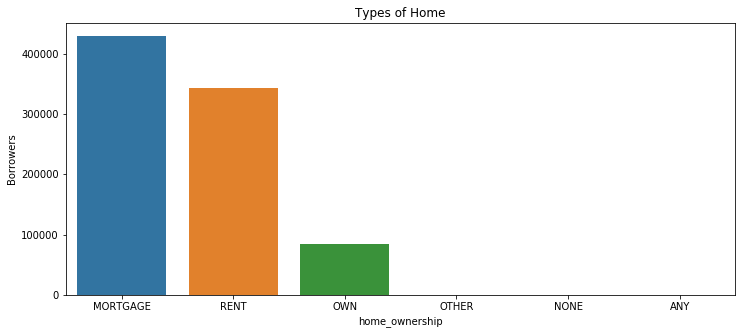

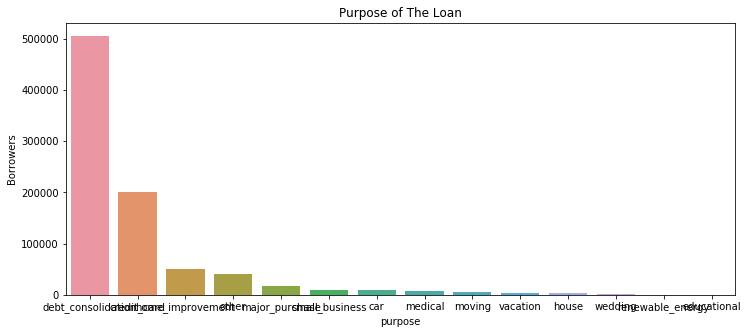

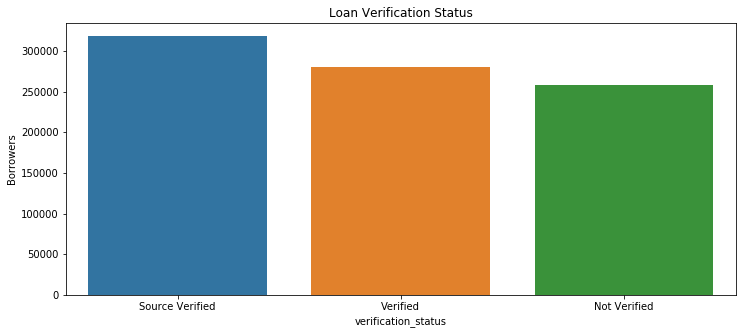

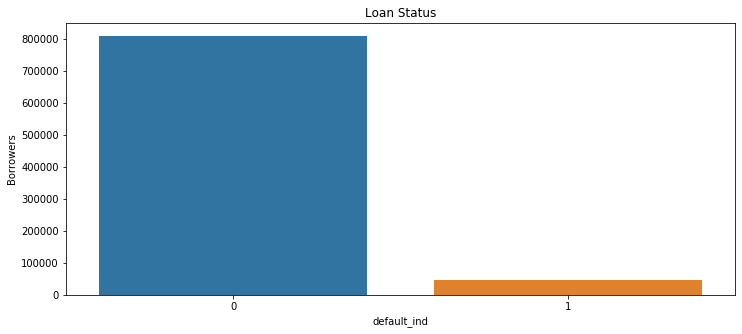

In [24]:
home=Full_Raw['home_ownership'].value_counts()
plt.figure(figsize=(12,5))
plt.title('Types of Home')
plt.xlabel('home_ownership')
plt.ylabel('Borrowers')
sns.barplot(x=home.index, y=home.values)

purpose=Full_Raw['purpose'].value_counts()
plt.figure(figsize=(12,5))
plt.title('Purpose of The Loan')
plt.ylabel('Borrowers')
plt.xlabel('purpose')
sns.barplot(x=purpose.index, y=purpose.values)

verifi_status=Full_Raw['verification_status'].value_counts()
plt.figure(figsize=(12,5))
plt.title('Loan Verification Status')
plt.ylabel('Borrowers')
plt.xlabel('verification_status')
sns.barplot(x=verifi_status.index , y=verifi_status.values)

default=Full_Raw['default_ind'].value_counts()
plt.figure(figsize=(12,5))
plt.title('Loan Status')
plt.ylabel('Borrowers')
plt.xlabel('default_ind')
sns.barplot(x=default.index, y= default.values)

## E. Outlier handling    

### Ploting Box plot and histograms 

To understand the distrubution of data.

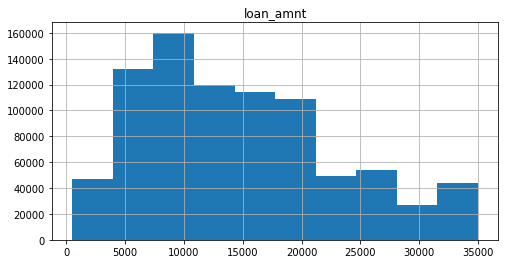

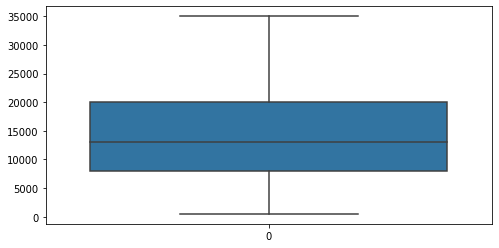

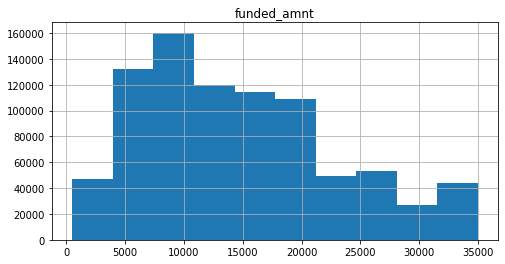

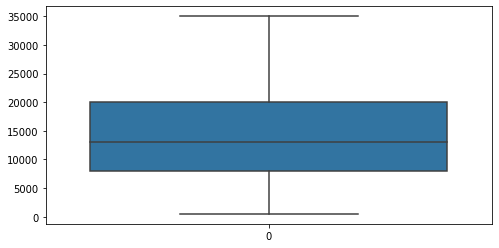

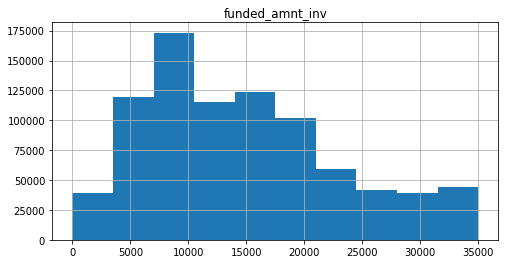

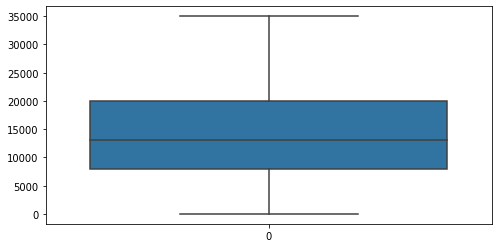

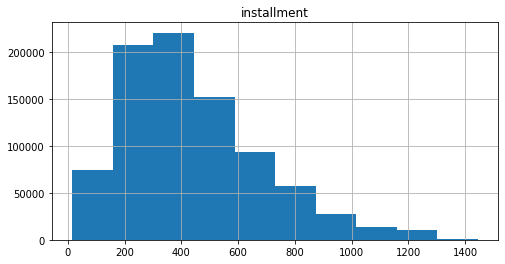

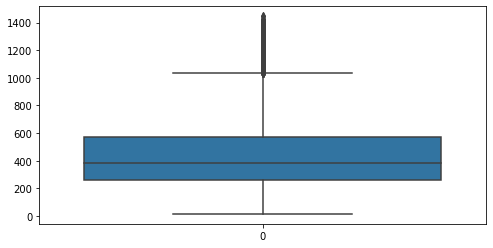

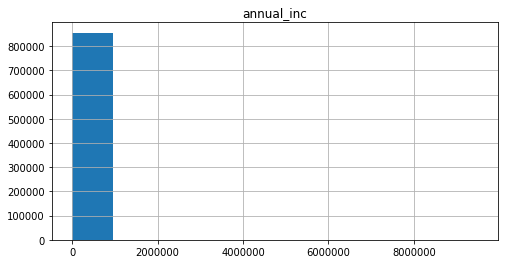

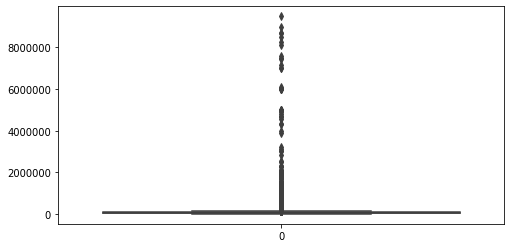

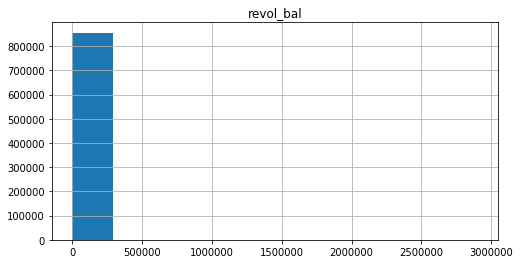

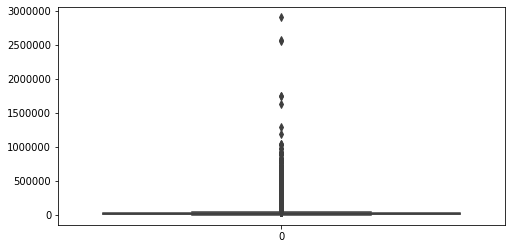

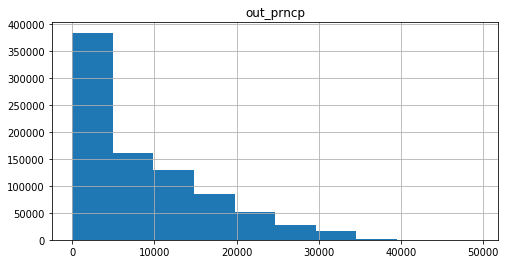

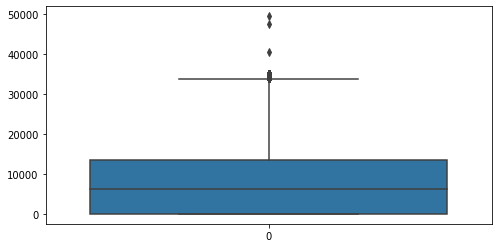

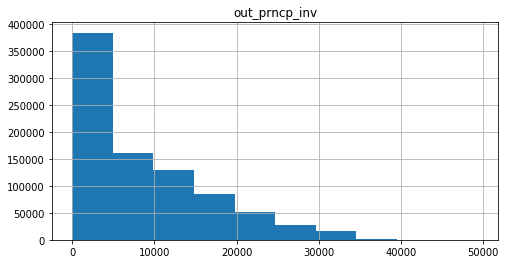

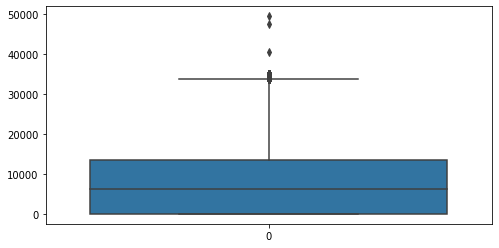

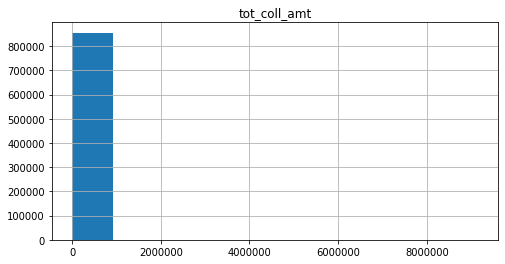

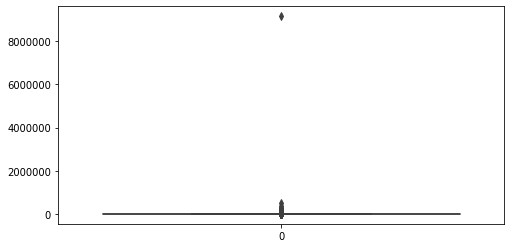

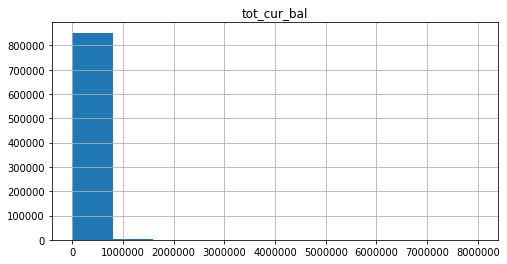

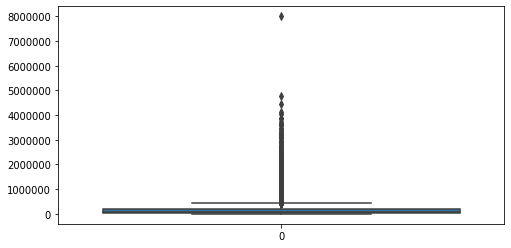

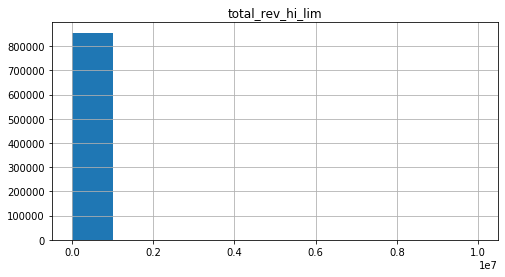

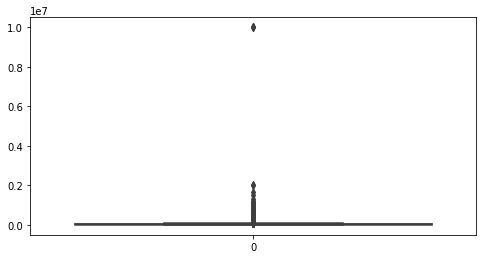

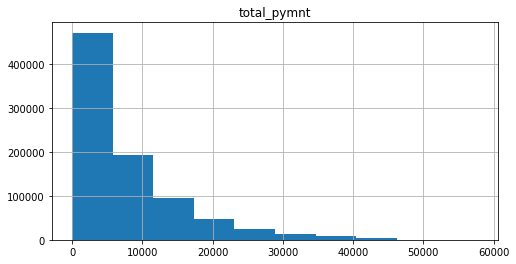

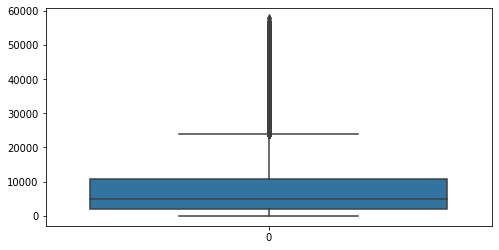

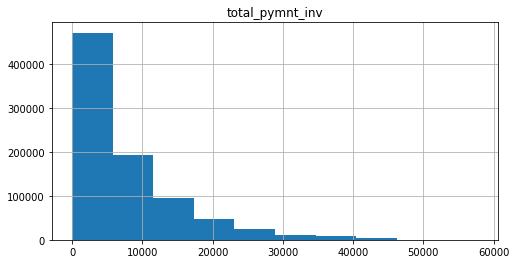

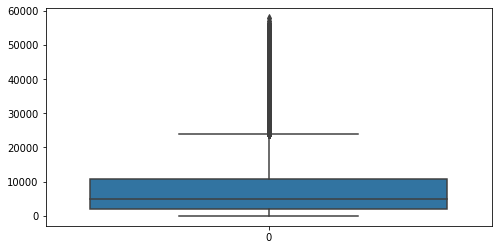

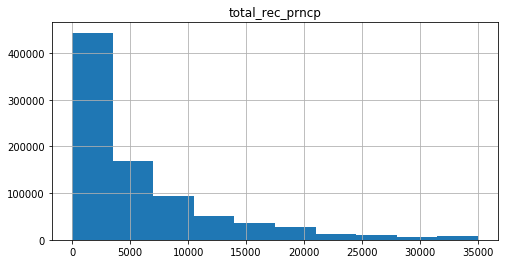

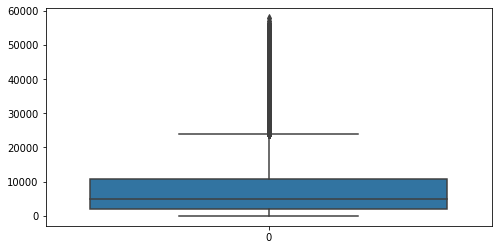

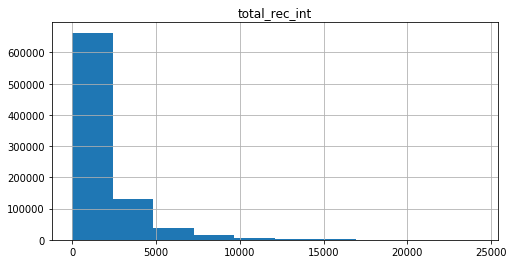

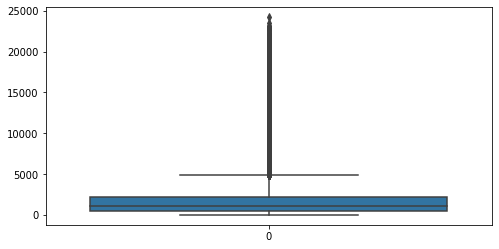

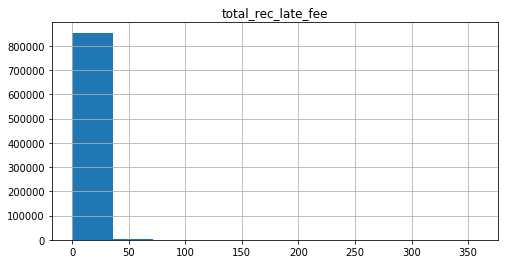

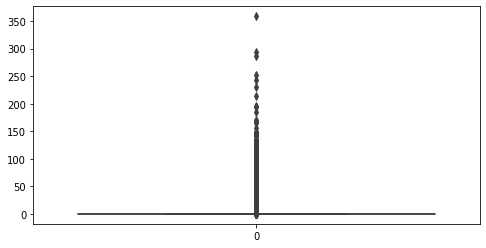

In [25]:
plt.rcParams.update({'figure.max_open_warning': 0})
%matplotlib inline
#loan_amnt
plt.figure(figsize=(8,4))
plt.title('loan_amnt')
Full_Raw["loan_amnt"].hist()
plt.figure(figsize=(8,4))
sns.boxplot(data=Full_Raw["loan_amnt"]) # no outlier

#funded_amnt
plt.figure(figsize=(8,4))
plt.title('funded_amnt')
Full_Raw["funded_amnt"].hist()
plt.figure(figsize=(8,4))
sns.boxplot(data=Full_Raw["funded_amnt"]) # no outlier

#funded_amnt_inv
plt.figure(figsize=(8,4))
plt.title('funded_amnt_inv')
Full_Raw["funded_amnt_inv"].hist()
plt.figure(figsize=(8,4))
sns.boxplot(data=Full_Raw["funded_amnt_inv"]) # no outlier

#installment     
plt.figure(figsize=(8,4))
plt.title('installment')
Full_Raw["installment"].hist()
plt.figure(figsize=(8,4))
sns.boxplot(data=Full_Raw["installment"]) # outlier

#annual_inc                          
plt.figure(figsize=(8,4))
plt.title('annual_inc')
Full_Raw["annual_inc"].hist()
plt.figure(figsize=(8,4))
sns.boxplot(data=Full_Raw["annual_inc"]) # outlier

#revol_bal                          
plt.figure(figsize=(8,4))
plt.title('revol_bal')
Full_Raw["revol_bal"].hist()
plt.figure(figsize=(8,4))
sns.boxplot(data=Full_Raw["revol_bal"]) # outlier

#out_prncp                          
plt.figure(figsize=(8,4))
plt.title('out_prncp')
Full_Raw["out_prncp"].hist()
plt.figure(figsize=(8,4))
sns.boxplot(data=Full_Raw["out_prncp"]) # mediam outlier

#out_prncp_inv                          
plt.figure(figsize=(8,4))
plt.title('out_prncp_inv')
Full_Raw["out_prncp_inv"].hist()
plt.figure(figsize=(8,4))
sns.boxplot(data=Full_Raw["out_prncp_inv"]) # mediam outlier

#tot_coll_amt    
plt.figure(figsize=(8,4))
plt.title('tot_coll_amt')
Full_Raw["tot_coll_amt"].hist()
plt.figure(figsize=(8,4))
sns.boxplot(data=Full_Raw["tot_coll_amt"]) #  outlier

#tot_cur_bal  
plt.figure(figsize=(8,4))
plt.title('tot_cur_bal')
Full_Raw["tot_cur_bal"].hist()
plt.figure(figsize=(8,4))
sns.boxplot(data=Full_Raw["tot_cur_bal"]) #  outlier

#total_rev_hi_lim       
plt.figure(figsize=(8,4))
plt.title('total_rev_hi_lim')
Full_Raw["total_rev_hi_lim"].hist()
plt.figure(figsize=(8,4))
sns.boxplot(data=Full_Raw["total_rev_hi_lim"]) #  outlier

#total_pymnt 
plt.figure(figsize=(8,4))
plt.title('total_pymnt')
Full_Raw["total_pymnt"].hist()
plt.figure(figsize=(8,4))
sns.boxplot(data=Full_Raw["total_pymnt"]) # medium outlier

#total_pymnt_inv         
plt.figure(figsize=(8,4))
plt.title('total_pymnt_inv')
Full_Raw["total_pymnt_inv"].hist()
plt.figure(figsize=(8,4))
sns.boxplot(data=Full_Raw["total_pymnt_inv"]) # medium outlier

#total_rec_prncp 
plt.figure(figsize=(8,4))
plt.title('total_rec_prncp')
Full_Raw["total_rec_prncp"].hist()
plt.figure(figsize=(8,4))
sns.boxplot(data=Full_Raw["total_pymnt_inv"]) # medium outlier

#total_rec_int      
plt.figure(figsize=(8,4))
plt.title('total_rec_int')
Full_Raw["total_rec_int"].hist()
plt.figure(figsize=(8,4))
sns.boxplot(data=Full_Raw["total_rec_int"]) #  outlier

#total_rec_late_fee 
plt.figure(figsize=(8,4))
plt.title('total_rec_late_fee')
Full_Raw["total_rec_late_fee"].hist()
plt.figure(figsize=(8,4))
sns.boxplot(data=Full_Raw["total_rec_late_fee"]) #  outlier


From the above plotted graphs we note that the following variables like **"installment", "annual_inc", "revol_bal", "out_prncp", "out_prncp_inv", "total_rec_late_fee", "total_rec_int", "total_rev_hi_lim", "tot_cur_bal",** etc  are **skewed towards one side** and thus indicates the presence of outliers. Also a box plot show large points beyond the **1.5 IQR marks** which confirms the presence of **outliers**.

We will handle the outliers using **Log transformation** and **Standard scaler**.


### Removing outliers 

In [26]:
np.seterr(divide = 'ignore') 
Outlier_Vars=[ "annual_inc", "revol_bal", "out_prncp", "out_prncp_inv", "tot_coll_amt", "tot_cur_bal", "total_rev_hi_lim",
              "total_rec_int", "total_rec_late_fee"]

for i in Outlier_Vars:
    Full_Raw[i+"_log"]=np.where(Full_Raw[i]==0,0,np.log(Full_Raw[i]))
    Full_Raw.drop(i, axis=1, inplace=True)

## F. Dummy Variable Creation

In [27]:
Full_Raw2=pd.get_dummies(Full_Raw, drop_first=True)
Full_Raw2.shape

(855969, 59)

## G. Dividing the Data Train and Test again

The Train data will be further divided into **Training (70% of Train Data)**, **Valid (30% of Train Data)** for model testing.

The **valid** dataset will be used for testing of models performance before being **implemented** in the Out of the Box data **(Test)**

In [28]:
#train test and validate data sets
Train_App=Full_Raw2[Full_Raw2["Source_Train"]==1].drop(["Source_Train"], axis=1).copy()
Test_App=Full_Raw2[Full_Raw2["Source_Train"]==0].drop(["Source_Train"], axis=1).copy()
print("Train full shape:",Train_App.shape, "and Test(OOB) full shape: ",Test_App.shape)

Train full shape: (598978, 58) and Test(OOB) full shape:  (256991, 58)


In [29]:
Features=[x for x in Train_App.columns if x!="default_ind"]
Dep_Var=Train_App["default_ind"]

Train_X, Valid_X, Train_Y, Valid_Y=train_test_split(Train_App[Features], Dep_Var, train_size=0.70, random_state=123)

Test_X=Test_App.drop(["default_ind"], axis=1).copy()
Test_Y=Test_App["default_ind"]

print("Train_X  shape:",Train_X.shape, "and Train_Y shape: ",Train_Y.shape)
print("Valid_X  shape:",Valid_X.shape, "and Valid_Y shape: ",Valid_Y.shape)
print("Test_X   shape:",Test_X.shape,  "and Test_Y shape:  ",Test_Y.shape)

Train_X  shape: (419284, 57) and Train_Y shape:  (419284,)
Valid_X  shape: (179694, 57) and Valid_Y shape:  (179694,)
Test_X   shape: (256991, 57) and Test_Y shape:   (256991,)


## G. Standard Scaling 

Most of the times, datasets will contain features which will be highly varying in magnitudes, units and range. 
But since, most of the machine learning algorithms use **Eucledian distance** between two data points in their computations, this will create a problem as they most use **magnitude of features neglecting their units**. 

In [30]:
Train_X.head(5)

,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,...,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,initial_list_status_w,application_type_JOINT
230895,35000.00000,35000.00000,35000.00000,17.86000,886.11000,10.81000,2.00000,1.00000,5.00000,1.00000,...,0,0,0,0,0,0,0,0,1,0
134759,10000.00000,10000.00000,10000.00000,11.14000,328.06000,14.91000,0.00000,0.00000,9.00000,1.00000,...,0,0,0,0,0,0,0,0,0,0
729158,8000.00000,8000.00000,8000.00000,8.18000,251.36000,11.63000,0.00000,1.00000,9.00000,0.00000,...,0,0,0,0,0,0,0,0,1,0
133437,12000.00000,12000.00000,12000.00000,19.05000,440.18000,11.65000,0.00000,1.00000,9.00000,0.00000,...,0,0,0,0,0,0,0,0,1,0
290446,12000.00000,12000.00000,12000.00000,12.49000,401.39000,29.97000,0.00000,0.00000,20.00000,0.00000,...,0,0,0,0,0,0,0,0,0,0


Here in our data shown above, "loan_amnt", "annual_inc" ranges from in thousands where as "int_rate", "dti" ranges in tens and some like "inq_last_6mths" range in units. So, Standard Scaling plays an significant role by replacing the values by their Z scores.

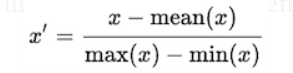

Standard model will be built on Train_X data set which will be implemented in Train_X itself and Valid_X and Test_X data sets respectively


In [31]:
#model Training
Train_Scaler=StandardScaler().fit(Train_X)
Train_X_Scaled=Train_Scaler.transform(Train_X)
Valid_X_Scaled=Train_Scaler.transform(Valid_X)
Test_X_Scaled=Train_Scaler.transform(Test_X)

In [32]:
#implementing StandardScaler
Train_X_Scaled=pd.DataFrame(Train_X_Scaled, columns=Train_X.columns)
Valid_X_Scaled=pd.DataFrame(Valid_X_Scaled, columns=Valid_X.columns)
Test_X_Scaled=pd.DataFrame(Test_X_Scaled, columns=Test_X.columns)

In [33]:
Train_X_Scaled.head(5)

,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,...,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,initial_list_status_w,application_type_JOINT
0,2.45358,2.45856,2.46061,0.99458,1.85842,-0.84629,2.05577,0.26678,-1.23675,1.49332,...,-0.14215,-0.09814,-0.07937,-0.22544,-0.02649,-0.11446,-0.07332,-0.06127,1.23556,0.00000
1,-0.54460,-0.54292,-0.53705,-0.54456,-0.43849,-0.33809,-0.35839,-0.73112,-0.45968,1.49332,...,-0.14215,-0.09814,-0.07937,-0.22544,-0.02649,-0.11446,-0.07332,-0.06127,-0.80935,0.00000
2,-0.78445,-0.78304,-0.77686,-1.22251,-0.75418,-0.74465,-0.35839,0.26678,-0.45968,-0.32484,...,-0.14215,-0.09814,-0.07937,-0.22544,-0.02649,-0.11446,-0.07332,-0.06127,1.23556,0.00000
3,-0.30474,-0.30280,-0.29724,1.26713,0.02299,-0.74217,-0.35839,0.26678,-0.45968,-0.32484,...,-0.14215,-0.09814,-0.07937,-0.22544,-0.02649,-0.11446,-0.07332,-0.06127,1.23556,0.00000
4,-0.30474,-0.30280,-0.29724,-0.23536,-0.13667,1.52861,-0.35839,-0.73112,1.67726,-0.32484,...,-0.14215,-0.09814,-0.07937,-0.22544,-0.02649,-0.11446,-0.07332,-0.06127,-0.80935,0.00000


Thus, the data has been standardized.

## H. Handling RARE class scenerio

## What is a RARE class

A rare class scenerio occurs when there is an imbalance in number of obervations in between two or more classes.



In [34]:
print(Train_Y.value_counts())
print("Percentage of Defaulter to Total data set: ",(Train_Y.value_counts()[1])/Train_Y.shape[0]*100)
print("Percentage of Defaulter to Total 0s or Majority class: ",(Train_Y.value_counts()[1])/(Train_Y.value_counts()[0])*100)

0    387009
1     32275
Name: default_ind, dtype: int64
Percentage of Defaulter to Total data set:  7.697646463971915
Percentage of Defaulter to Total 0s or Majority class:  8.339599337483108


Here we can note that the "Non Defaulter Class" out-balances the "Defaulter Class" which indicates **class imbalance** or the rare class scenerio.

With only **7.7% (approx) of "Defaulters" when compared to fulldata dataset** and **8.34% when compared to "Non Defaulters" in the dataset**. the classes are **highly imbalanced**.

The conventional model evaluation methods do not accurately measure model performance when faced with imbalanced datasets.

Standard classifier algorithms like Decision Tree (including Random Forest) and Logistic Regression have a bias towards classes which have number of instances. They tend to only predict the majority class data. The features of the minority class are treated as noise and are often ignored. Thus, there is a high probability of misclassification of the minority class as compared to the majority class.

If the minority class has **less than 25% of total majority class** it is generally considered as Rare class or **"Imbalanced Class"**

So we will use **SMOTE*** from IMBLEARN to improve the condition of the minority class.

**SMOTE Synthetic Minority Oversampling Technique**
Creating new examples, synthesized from the existing examples

In [35]:
SMT = SMOTE(sampling_strategy=0.65, n_jobs=-2) 
Train_X_SMT, Train_Y_SMT = SMT.fit_sample(Train_X_Scaled, Train_Y) 

print(Train_Y_SMT.value_counts())
print("Percentage of Defaulter to Total data set: ",(Train_Y_SMT.value_counts()[1])/Train_Y_SMT.shape[0]*100)
print("Percentage of Defaulter to Total 0s or Majority class: ",(Train_Y_SMT.value_counts()[1])/(Train_Y_SMT.value_counts()[0])*100)

0    387009
1    251555
Name: default_ind, dtype: int64
Percentage of Defaulter to Total data set:  39.393858720504134
Percentage of Defaulter to Total 0s or Majority class:  64.99978036686485


## I. Variable importance check

 We will use Random Forest in default parameters to find out the **"feature_importances_"** and based on that we will drop the 5 variables of least importance

In [36]:
Model1_VI_RF=RandomForestClassifier(random_state=123, n_jobs=-2, 
                                    class_weight="balanced_subsample").fit(Train_X_SMT, Train_Y_SMT)
#variable importance
Var_Imp=pd.concat([pd.DataFrame(Model1_VI_RF.feature_importances_), pd.DataFrame(Train_X_SMT.columns)], axis=1)
Var_Imp.columns=["values", "Features"]
Var_Imp.sort_values(["values"], inplace=True)
variableworst=Var_Imp[:5]

In [37]:
variableworst

,values,Features
56,0.00000,application_type_JOINT
41,0.00000,pymnt_plan_y
19,0.00000,policy_code
35,0.00000,home_ownership_NONE
51,0.00000,purpose_renewable_energy


Removing the top 5 non-impacting variables

In [38]:
Train_X_SMT.drop(variableworst.Features, axis=1, inplace=True)
Valid_X_Scaled.drop(variableworst.Features, axis=1, inplace=True)
Test_X_Scaled.drop(variableworst.Features, axis=1, inplace=True)

print(Train_X_SMT.shape)
print(Valid_X_Scaled.shape)
print(Valid_X_Scaled.shape)

(638564, 52)
(179694, 52)
(179694, 52)


# Model building

We will build 3 models all together.
1. Random Forest 
2. Logistic Regression
3. Stacking Classifier which will be an ensemble model of both Random Forest (Random Forest Classifier), Logistic Regression and Rigde Classifier (the Ridge Classifier) will work as a penalizing tool.
4. We will use **GridSearchCV** to determined parameters for hyptertuning.

## Random Forest Classifier

Before we build a model with RandomForest, but, we will first use GridSearchCv to find the correct parameters to fine tune the model

#### GridSearchCV

Grid search is the process of performing hyper parameter tuning in order to determine the optimal values for a given model. This is significant as the performance of the entire model is based on the hyper parameter values specified.

Since the data is quite large we will perform the Grid Search in a sample of 20% of the Train Data and Cross validation folds as 3.

In [39]:
#Grid Search Sample

Grid_Sample=pd.concat([Train_X_SMT, Train_Y_SMT],axis=1)
Grid_Features=[x for x in Grid_Sample.columns if x!=("default_ind")]
Grid_Dep_Var=Grid_Sample["default_ind"]
GridX,DX,GridY,DY=train_test_split(Grid_Sample[Grid_Features],Grid_Dep_Var, train_size=0.20, random_state=4)

In [48]:
params={"max_features":["auto", "sqrt"], "max_leaf_nodes":range(26,40,2), "min_samples_leaf":range(6,20,2), 
        "min_samples_split": range(1,5,2), "n_estimators":range(100,300,100)}

Grid=GridSearchCV(estimator=RandomForestClassifier(random_state=4, 
                                   class_weight="balanced_subsample",n_jobs=-1), param_grid=params, scoring="f1", n_jobs=-1, 
                                      pre_dispatch="2*n_jobs", verbose=3,cv=3).fit(GridX, GridY)

Fitting 3 folds for each of 392 candidates, totalling 1176 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  7.0min
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed: 16.4min
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed: 30.1min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 47.5min
[Parallel(n_jobs=-1)]: Done 1144 tasks      | elapsed: 68.9min
[Parallel(n_jobs=-1)]: Done 1176 out of 1176 | elapsed: 71.2min finished


In [49]:
Grid_CV_Results_RF=pd.DataFrame.from_dict(Grid.cv_results_)
Grid_CV_Results_RF.sort_values("rank_test_score", ascending=True)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_features,param_max_leaf_nodes,param_min_samples_leaf,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
371,33.37410,0.19231,1.65358,0.06670,sqrt,38,8,3,200,"{'max_features': 'sqrt', 'max_leaf_nodes': 38,...",0.98667,0.98710,0.98621,0.98666,0.00036,1
175,33.70892,0.32860,1.47239,0.09024,auto,38,8,3,200,"{'max_features': 'auto', 'max_leaf_nodes': 38,...",0.98667,0.98710,0.98621,0.98666,0.00036,1
367,32.88000,0.44336,1.62598,0.02575,sqrt,38,6,3,200,"{'max_features': 'sqrt', 'max_leaf_nodes': 38,...",0.98676,0.98701,0.98619,0.98665,0.00035,3
171,32.11744,0.16613,1.52858,0.08389,auto,38,6,3,200,"{'max_features': 'auto', 'max_leaf_nodes': 38,...",0.98676,0.98701,0.98619,0.98665,0.00035,3
379,32.47681,0.42049,1.84341,0.35275,sqrt,38,12,3,200,"{'max_features': 'sqrt', 'max_leaf_nodes': 38,...",0.98669,0.98701,0.98615,0.98662,0.00035,5
183,32.54108,0.25114,1.67818,0.22807,auto,38,12,3,200,"{'max_features': 'auto', 'max_leaf_nodes': 38,...",0.98669,0.98701,0.98615,0.98662,0.00035,5
387,33.12175,0.27634,1.52426,0.15902,sqrt,38,16,3,200,"{'max_features': 'sqrt', 'max_leaf_nodes': 38,...",0.98666,0.98704,0.98612,0.98661,0.00038,7
191,35.26086,0.24448,1.55285,0.31109,auto,38,16,3,200,"{'max_features': 'auto', 'max_leaf_nodes': 38,...",0.98666,0.98704,0.98612,0.98661,0.00038,7
383,35.94505,0.40997,1.61302,0.09024,sqrt,38,14,3,200,"{'max_features': 'sqrt', 'max_leaf_nodes': 38,...",0.98663,0.98698,0.98621,0.98661,0.00031,9
187,32.89702,0.02118,1.57645,0.02298,auto,38,14,3,200,"{'max_features': 'auto', 'max_leaf_nodes': 38,...",0.98663,0.98698,0.98621,0.98661,0.00031,9


Based on the Grid seach, we have updated the model parameters

In [50]:
Model_2_RF=RandomForestClassifier(random_state=4, n_jobs=-1, class_weight="balanced",
                                 max_features='sqrt', max_leaf_nodes=38,  min_samples_leaf=8, 
                                 min_samples_split=3,n_estimators=200, oob_score=True).fit(Train_X_SMT, Train_Y_SMT)

## Logistic Regression

Second model we will be building is using Logistic Regression and its paremeters will be determinied by GridSearchCV

In [51]:
#GridSearch to hyptertune parameters

params={"penalty":["l1", "l2", "elasticnet"], "C": np.logspace(0,4,10)}

Grid=GridSearchCV(estimator=LogisticRegression(n_jobs=-1, fit_intercept=True, 
                                               class_weight="balanced"), param_grid=params, scoring="f1", n_jobs=-1, 
                                                  pre_dispatch="2*n_jobs",cv=3).fit(GridX, GridY)

In [52]:
Grid_CV_Results_LR=pd.DataFrame.from_dict(Grid.cv_results_)
Grid_CV_Results_LR.sort_values("rank_test_score", ascending=True)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_penalty,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
22,2.44213,0.05875,0.02593,0.00163,1291.54967,l2,"{'C': 1291.5496650148827, 'penalty': 'l2'}",0.97534,0.97614,0.97673,0.97607,0.00057,1
13,2.47106,0.02916,0.02726,0.00169,59.94843,l2,"{'C': 59.94842503189409, 'penalty': 'l2'}",0.97520,0.97592,0.97666,0.97593,0.00060,2
25,2.41920,0.10853,0.03225,0.00578,3593.81366,l2,"{'C': 3593.813663804626, 'penalty': 'l2'}",0.97496,0.97591,0.97685,0.97591,0.00077,3
28,1.96873,0.32087,0.02427,0.00169,10000.00000,l2,"{'C': 10000.0, 'penalty': 'l2'}",0.97478,0.97589,0.97639,0.97569,0.00067,4
19,2.41236,0.02497,0.02793,0.00294,464.15888,l2,"{'C': 464.15888336127773, 'penalty': 'l2'}",0.97519,0.97558,0.97604,0.97560,0.00035,5
10,2.41886,0.01324,0.02693,0.00000,21.54435,l2,"{'C': 21.544346900318832, 'penalty': 'l2'}",0.97456,0.97600,0.97610,0.97555,0.00071,6
7,2.44546,0.03863,0.02660,0.00094,7.74264,l2,"{'C': 7.742636826811269, 'penalty': 'l2'}",0.97443,0.97616,0.97598,0.97552,0.00077,7
16,2.37797,0.06149,0.02759,0.00124,166.81005,l2,"{'C': 166.81005372000593, 'penalty': 'l2'}",0.97517,0.97589,0.97533,0.97546,0.00031,8
4,2.40257,0.06399,0.02793,0.00141,2.78256,l2,"{'C': 2.7825594022071245, 'penalty': 'l2'}",0.97405,0.97549,0.97480,0.97478,0.00058,9
1,2.37398,0.04701,0.02793,0.00141,1.00000,l2,"{'C': 1.0, 'penalty': 'l2'}",0.97323,0.97526,0.97413,0.97421,0.00083,10


In [53]:
Model_3_LR=LogisticRegression(max_iter=500,penalty="l2",C=10000, fit_intercept=True,class_weight="balanced", 
                              n_jobs=-1).fit(Train_X_SMT, Train_Y_SMT)

## Stacking Classifier

Lastly we will combine all the models and make a Stacking Classifier that will use majority voting to find out the class of borrower

In [54]:
#GridSearch for RidgeClassifier

params={"alpha":[1.0,2.0,5.0,8.0,10.0, 0.1,0.01, 0.001], "normalize":[True, False]}
Grid=GridSearchCV(estimator=RidgeClassifier(fit_intercept=True, class_weight="balanced"), 
                  param_grid=params, scoring="f1", n_jobs=-1, pre_dispatch="2*n_jobs",cv=3).fit(GridX, GridY)

In [55]:
Grid_CV_Results_RC=pd.DataFrame.from_dict(Grid.cv_results_)
Grid_CV_Results_RC.sort_values("rank_test_score", ascending=True)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_normalize,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
15,0.32879,0.02770,0.02493,0.00163,0.00100,False,"{'alpha': 0.001, 'normalize': False}",0.91523,0.92024,0.91805,0.91784,0.00205,1
13,0.35738,0.01910,0.03025,0.00329,0.01000,False,"{'alpha': 0.01, 'normalize': False}",0.91520,0.92016,0.91803,0.91780,0.00203,2
11,0.35638,0.00901,0.03258,0.00094,0.10000,False,"{'alpha': 0.1, 'normalize': False}",0.91517,0.92009,0.91803,0.91777,0.00201,3
3,0.45046,0.02304,0.03823,0.00757,2.00000,False,"{'alpha': 2.0, 'normalize': False}",0.91517,0.92004,0.91806,0.91776,0.00200,4
1,0.40292,0.05783,0.04122,0.00757,1.00000,False,"{'alpha': 1.0, 'normalize': False}",0.91517,0.92004,0.91803,0.91775,0.00199,5
5,0.56881,0.00908,0.05020,0.01031,5.00000,False,"{'alpha': 5.0, 'normalize': False}",0.91510,0.92004,0.91806,0.91773,0.00203,6
7,0.45379,0.02617,0.03491,0.00587,8.00000,False,"{'alpha': 8.0, 'normalize': False}",0.91510,0.92001,0.91799,0.91770,0.00201,7
9,0.37200,0.01341,0.02693,0.00141,10.00000,False,"{'alpha': 10.0, 'normalize': False}",0.91510,0.92001,0.91794,0.91768,0.00201,8
14,0.37832,0.00402,0.03225,0.00632,0.00100,True,"{'alpha': 0.001, 'normalize': True}",0.91486,0.91965,0.91764,0.91738,0.00197,9
12,0.37599,0.00826,0.02959,0.00094,0.01000,True,"{'alpha': 0.01, 'normalize': True}",0.91336,0.91763,0.91563,0.91554,0.00174,10


In [56]:
# 03: Stacking Classifier
algos = [("RF",RandomForestClassifier(random_state=4,max_features='sqrt', 
                                      max_leaf_nodes=38,min_samples_leaf=8, min_samples_split=3, n_estimators=200, 
                                      class_weight="balanced")),
         ("RCV", RidgeClassifier(alpha=0.01,normalize=False, fit_intercept=True, class_weight="balanced"))]
Model_4_SC=StackingClassifier(estimators=algos, 
                              final_estimator=LogisticRegression(max_iter=500,random_state=123, 
                                                             fit_intercept=True, n_jobs=-2,
                                                             C=10000, class_weight="balanced")).fit(Train_X_SMT, Train_Y_SMT)

## Model testing

**All model testing will be done using Valid_X data set and the model's performance will be measured with Valid_Y dataset**

In [57]:
Models_Dict={"LR":Model_3_LR, "RF":Model_2_RF, "SC":Model_4_SC}

## Cutoff Point determination

Cutoff point helps us to tune the sensivity of the model thus help us to correctly predict the defaulters and also reduce the possibility of creating false positive predictions.

This Cutoff points helps in reducing both False Positives and most essentially False Negatives.

**False Positives** are the one's who are **not "de-faulters" in real scenerio** but are identified as **"defaulters" by the model** and thus these could be cause of **potential business losses** as banks may deny loans to them thus **reducing the creation of assets** and also **reducing the source of income i.e. interests from loans.**

**False Negatives** are the once who are **"de-faulters" in real scenerio** but are identified as **"not defaulters" by the model**, this leads to serious consequenses like **loss of assets**, **creation of high Non Performing Assets**, **regulatory issues**, **loss of license**, **imbalance in assets and liabilities**, **inability to generate revenues**, **employment compensation issues** etc.

In [58]:
Cut_off_Points=pd.DataFrame()
counter=0
for Model_Name, Model_Algo in zip(Models_Dict.keys(), Models_Dict.values()):
    train_probab=Model_Algo.predict_proba(Train_X_SMT)[:,1]
    fpr, tpr, cutoff=roc_curve(Train_Y_SMT, train_probab)
    temp_cut_off=pd.DataFrame({"model":Model_Name,
                               "fpr":fpr,
                               "tpr":tpr,
                               "cutoff":cutoff,
                               "minDist":np.sqrt(((1-tpr)**2)+((0-fpr)**2)),
                               "maxDiff":tpr-fpr})
    temp_dist=temp_cut_off[temp_cut_off["minDist"]==temp_cut_off["minDist"].min()]
    Cut_off_Points=Cut_off_Points.append(temp_dist, ignore_index=True)
    temp_diff=temp_cut_off[temp_cut_off["maxDiff"]==temp_cut_off["maxDiff"].max()]
    Cut_off_Points=Cut_off_Points.append(temp_diff, ignore_index=True)
    counter=counter+1
Avg_cutoff=round(sum(Cut_off_Points["cutoff"])/(counter*2),3)

In [59]:
Cut_off_Points

,model,fpr,tpr,cutoff,minDist,maxDiff
0,LR,0.01226,0.97539,0.52508,0.02750,0.96313
1,LR,0.00714,0.97216,0.62789,0.02874,0.96502
2,RF,0.00780,0.97917,0.39096,0.02225,0.97137
3,RF,0.00272,0.97672,0.45963,0.02344,0.97400
4,SC,0.00648,0.97874,0.46426,0.02223,0.97226
5,SC,0.00263,0.97645,0.65498,0.02370,0.97383


In [60]:
Avg_cutoff

0.52

## Testing the model performance in Valid Dataset

In [61]:
cutoff_points_List=Cut_off_Points["cutoff"]
Model_Reports=pd.DataFrame()
for Model_Name, Model_Algo in zip(Models_Dict.keys(), Models_Dict.values()):
    Valid_Pred_Prob=Model_Algo.predict_proba(Valid_X_Scaled)[:,1]
    for cutoff in cutoff_points_List:
        Valid_Pred=np.where(Valid_Pred_Prob>cutoff,1,0)
        tempmat=pd.Series({ "estimator name":Model_Name,
                            "confusion_mat":confusion_matrix(Valid_Y, Valid_Pred),
                            "precision_score":precision_score(Valid_Y, Valid_Pred),
                            "recall":recall_score(Valid_Y, Valid_Pred),
                            "f1 score":f1_score(Valid_Y, Valid_Pred),
                            "accuracy":sum(np.diagonal(confusion_matrix(Valid_Pred, Valid_Y)))/Valid_Y.shape[0]*100,
                            "cohen_kappa score":cohen_kappa_score(Valid_Y, Valid_Pred),
                            "cutoff_shift":cutoff-Avg_cutoff,
                            "Cutoff Point":cutoff})
        Model_Reports=Model_Reports.append(tempmat, ignore_index=True)

In [62]:
print("Confusion Matrix Legend: \"tn, fp, fn, tp\"")
Model_Reports

Confusion Matrix Legend: "tn, fp, fn, tp"


,Cutoff Point,accuracy,cohen_kappa score,confusion_mat,cutoff_shift,estimator name,f1 score,precision_score,recall
0,0.52508,98.63268,0.90835,"[[163881, 1932], [525, 13356]]",0.00508,LR,0.91577,0.87363,0.96218
1,0.62789,99.05896,0.93505,"[[164721, 1092], [599, 13282]]",0.10789,LR,0.94015,0.92403,0.95685
2,0.39096,97.75507,0.85710,"[[162251, 3562], [472, 13409]]",-0.12904,LR,0.86925,0.79011,0.96600
3,0.45963,98.25648,0.88578,"[[163175, 2638], [495, 13386]]",-0.06037,LR,0.89523,0.83537,0.96434
4,0.46426,98.29321,0.88794,"[[163244, 2569], [498, 13383]]",-0.05574,LR,0.89719,0.83895,0.96412
5,0.65498,99.14410,0.94053,"[[164899, 914], [624, 13257]]",0.13498,LR,0.94517,0.93550,0.95505
6,0.52508,99.60377,0.97170,"[[165730, 83], [629, 13252]]",0.00508,RF,0.97384,0.99378,0.95469
7,0.62789,99.52363,0.96562,"[[165810, 3], [853, 13028]]",0.10789,RF,0.96819,0.99977,0.93855
8,0.39096,99.00776,0.93232,"[[164492, 1321], [462, 13419]]",-0.12904,RF,0.93770,0.91038,0.96672
9,0.45963,99.45908,0.96193,"[[165378, 435], [537, 13344]]",-0.06037,RF,0.96486,0.96843,0.96131


1. RandomForest seems doing well at first glance but refering to "f1 score", "precision score" and "recall" it seems to have overfitted the data

2. Logistic Regression may have been underfitted the model and also the "fn" or false negatives are very high which is undesirable.

3. Stacking Classifier combined both of them and did a pretty decent job so we will use Stacking Classifier for our prediction

## Predicting on Out of the Box or Unseen data aka the Test Data set

In [63]:
#testing in TEST data set
Test_Pred_Prob=Model_4_SC.predict_proba(Test_X_Scaled)[:,1]
Test_Pred=np.where(Test_Pred_Prob>0.66,1,0)
Model_Test_Reports=pd.DataFrame()
finalmat=pd.Series({"Confusion matrix":confusion_matrix(Test_Y, Test_Pred),
                    "Precision score":precision_score(Test_Y, Test_Pred),
                    "Recall Score":recall_score(Test_Y, Test_Pred),
                    "f1 score":f1_score(Test_Y, Test_Pred),
                    "accuracy":sum(np.diagonal(confusion_matrix(Test_Pred, Test_Y)))/Test_Y.shape[0]*100,
                    "cohen kappa score":cohen_kappa_score(Test_Y, Test_Pred)})
Model_Test_Reports=Model_Test_Reports.append(finalmat, ignore_index=True).transpose()

In [64]:
print("Confusion Matrix Legend: \"tn, fp, fn, tp\"")
Model_Test_Reports

Confusion Matrix Legend: "tn, fp, fn, tp"


,0
Confusion matrix,"[[256586, 94], [63, 248]]"
Precision score,0.72515
Recall Score,0.79743
accuracy,99.93891
cohen kappa score,0.75927
f1 score,0.75957


So based on the output we have 63 False negatives and 94 False Positives. 

1. False negatives are those who are defaulters in real scenerio but the model fails to classifies them defaulters. It negatively impacts the business  as these are potential losses. Our model made 63 false negatives predictions out of "256991" sample data which is almost <0.025%. (approx)

2. False positives are those who are "non defaulters" in real scenerio but the model classifies them defaulters. These are also potential loss for the business as it could lead to loan application rejection and thus loss of revenue and asset creation. But they can also be dealt as "Doubtful borrowers" who might be pushed to further scrutiny or be given a loan at slightly higher interest rates or with sufficient co-laterals or guaranters.

3. The Recall score or ability of a model to find all the relevant cases within a dataset shows the score of 0.797 or almost 80% 

4. Very high Accuracy of almost 100% shows the presence of Rare class event, but the models are developed with balance-weighted methods so this metric high value can be ignored.

5. Cohen Kappa score: Acccording to Cohen's original article, values ≤ 0 as indicating no agreement and 0.01–0.20 as none to slight, 0.21–0.40 as fair, 0.41– 0.60 as moderate, 0.61–0.80 as substantial, and 0.81–1.00 as almost perfect agreement. Our prediction model has a cohen kappa score of 0.76 which is in "substantial aggrement".

6. F1 score is also well balanced of approx 0.76 which indicates good aggrement between TP, FP, FN, TN